In [1]:
"""
Implementation of a simple for-loop backtesting strategy on a dual moving average strategy
"""

'\nImplementation of a simple for-loop backtesting strategy\n'

In [9]:
# we import library first
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
from collections import deque

In [12]:
# we load the amzn data
def load_financial_data(start_date,end_date,output_file):
    try:
        df = pd.read_pickle(output_file)
    except FileNotFoundError:
        df = data.DataReader('AMZN','yahoo',start_date,end_date)
        df.to_pickle(output_file)
    return df

In [14]:
amzn_data = load_financial_data('2015-01-01','2020-01-01','amzn_data.pkl')
amzn_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,15.737500,15.348000,15.629000,15.426000,55664000,15.426000
2015-01-05,15.419000,15.042500,15.350500,15.109500,55484000,15.109500
2015-01-06,15.150000,14.619000,15.112000,14.764500,70380000,14.764500
2015-01-07,15.064000,14.766500,14.875000,14.921000,52806000,14.921000
2015-01-08,15.157000,14.805500,15.016000,15.023000,61768000,15.023000
...,...,...,...,...,...,...
2019-12-24,89.778503,89.378998,89.690498,89.460503,17626000,89.460503
2019-12-26,93.523003,89.974998,90.050499,93.438499,120108000,93.438499
2019-12-27,95.070000,93.300499,94.146004,93.489998,123732000,93.489998


In [15]:
# our main strategy is a trend-following strategy, and the metrics we use
# are two SMA: 20-day SMA and 40-day SMA

In [21]:
def average(nums): # define a function for calculating the average of a list
    return sum(nums) / len(nums)
    

In [32]:
class NaiveBacktest():
    # define the initial function
    def __init__(self):
        self.shortSMA = deque()
        self.longSMA = deque()
        # we define some variables to record positions, cash, current position holdings,
        # and total (current positon holdings + cash)
        self.list_positions = [] # for visualization purpose
        self.list_cash = []
        self.list_holdings = []
        self.list_total = []
        
        # we define several signals for showing when we should buy or sell
        self.long_signal = False
        self.position = 0 # we set the number of shares we can buy to 10
        self.cash = 100000 # we use 100000 as our initial cash
        self.holdings = 0
        self.total = 0
        
        # define a function to create signals based on the price updates
    def create_signal(self,price_update):
        self.shortSMA.append(price_update['price'])
        self.longSMA.append(price_update['price'])

        # check whether current two SMA lists have exceeded the time period we have set
        if len(self.shortSMA) > 20:
            self.shortSMA.popleft()
        if len(self.longSMA) > 40:
            self.longSMA.popleft()

        # the rule for the creation of trading signal is:
        # as the size os shortSMA = 20
        # we can begin our compare
        if len(self.shortSMA) == 20:
            # check for their average
            if average(self.shortSMA) > average(self.longSMA):
                # we set our trend-following signal
                self.long_signal = True
            else:
                self.long_signal = False
            return True # we return true, represents that we are indeed creating a signal
        return False # we don't compare two SMA, no signal has been produced
    
    # define a function to check whether we should act based on the signal
    def buy_sell_hold(self,price_update):
        if self.long_signal and self.position <= 0: # enter a long position / buy some back in a short position
            print(str(price_update['date'])+" send buy orders for 10 shares @ "+str(price_update['price']))
            self.position += 10
            self.cash -= 10 * price_update['price']
        elif not self.long_signal and self.position > 0:
            # enter a short position 
            # the system doesn't not support short selling now
            # as it will be difficult to update the cash acmount
            print(str(price_update['date'])+" send sell orders for 10 shares @ "+str(price_update['price']))
            self.position -= 10
            self.cash += 10 * price_update['price']
        # for other values, we don't act, we hold
        
        # calculate the value of our current holdings with respect to current market price
        self.holdings = self.position * price_update['price']
        self.total = self.holdings + self.cash
        # show those variables
        print('%s total=%d, holding=%d, cash=%d' % (str(price_update['date']),self.total, self.holdings, self.cash))
        # we append them to our list for visualization
        self.list_holdings.append(self.holdings)
        self.list_positions.append(self.position)
        self.list_total.append(self.total)
        self.list_cash.append(self.cash)
            

In [33]:
# now we check how our naive backtester works
backtester = NaiveBacktest()

In [34]:
# we turn our adj close and date to tuples for backtesting
for t in zip(amzn_data.index,amzn_data['Adj Close']):
    date = t[0]
    price = t[1]
    # we turn them into a simple dictionary
    info = {'date':date,'price':price}
    
    # check whether there is a signal
    if backtester.create_signal(info):
        # we call our buy_sell_hold function
        backtester.buy_sell_hold(info)

2015-01-30 00:00:00 total=100000, holding=0, cash=100000
2015-02-02 00:00:00 total=100000, holding=0, cash=100000
2015-02-03 00:00:00 send buy orders for 10 shares @ 18.177499771118164
2015-02-03 00:00:00 total=100000, holding=181, cash=99818
2015-02-04 00:00:00 total=100000, holding=182, cash=99818
2015-02-05 00:00:00 total=100005, holding=186, cash=99818
2015-02-06 00:00:00 total=100005, holding=187, cash=99818
2015-02-09 00:00:00 total=100003, holding=185, cash=99818
2015-02-10 00:00:00 total=100004, holding=186, cash=99818
2015-02-11 00:00:00 total=100005, holding=187, cash=99818
2015-02-12 00:00:00 total=100006, holding=188, cash=99818
2015-02-13 00:00:00 total=100009, holding=190, cash=99818
2015-02-17 00:00:00 total=100005, holding=187, cash=99818
2015-02-18 00:00:00 total=100004, holding=186, cash=99818
2015-02-19 00:00:00 total=100007, holding=189, cash=99818
2015-02-20 00:00:00 total=100010, holding=191, cash=99818
2015-02-23 00:00:00 total=100008, holding=190, cash=99818
201

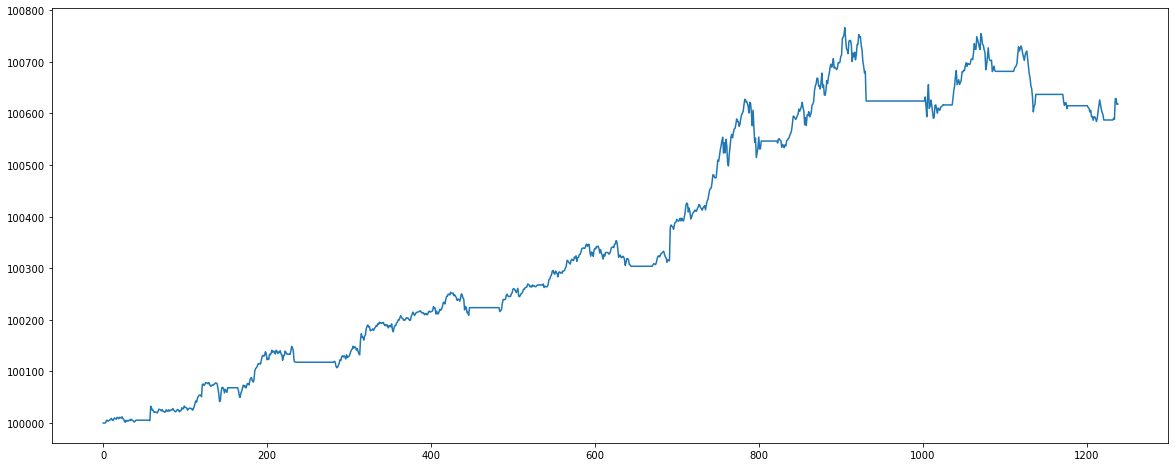

In [37]:
# we visualize how our position and cash has changed...
plt.figure(figsize = (20,8))
plt.plot(backtester.list_total, label = 'Holdings + Cash')

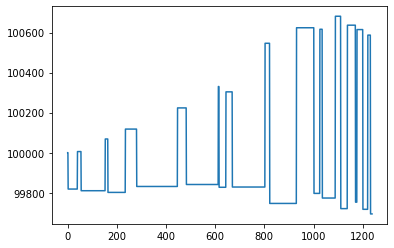

In [38]:
# we check how our cash has changed
plt.plot(backtester.list_cash, label = 'Cash')

In [ ]:
# ... it seems to have a lot of volatility ...
# apparently, we only care about the price updated from data stream
# we don't consider other factors, e.g. transaction costs.
# it might not be accurate ---> we will create an event-base backtest systems to check it